In [72]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator
 
from qiskit_aer.noise import (
    NoiseModel,
)

### Oracle for balanced/constant function

$$
U_f =
\begin{cases}
1 & \text{if } f(x) = 1 \\
\text{balanced} & \text{if } f(x) = 0 \text{ for half of the inputs and } f(x) = 1 \text{ for the other half} \\
0 & \text{if } f(x) = 0
\end{cases}
$$

In [73]:
def make_oracle(num_qubits):
    oracle_gate = QuantumCircuit(num_qubits, name="U_f")

    oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
    if oracleType == 0:
        print("Oracle type: constant")
        print("Oracle value: {}".format(oracleValue))

        if oracleValue == 1:
            oracle_gate.x(num_qubits - 1)
        else:
            oracle_gate.id(num_qubits - 1)

    else:
        print("Oracle type: balanced")
        a = np.random.randint(2 ** num_qubits) # Used fir balanced oracle

        for i in range(num_qubits - 1):
            if a & (1 << i):
                oracle_gate.cx(i, num_qubits - 1)

    # Make the circuit a unitary operator
    oracle_gate = oracle_gate.to_gate()
    oracle_gate.name = "U_f"

    return oracle_gate

Step 1: Apply Hadamard gate to all qubits and make the last qubit $|-\rangle$ state.

$$
\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle |-\rangle
$$

In [74]:
n = 3

qr = QuantumRegister(n)
out = QuantumRegister(1)
cr = ClassicalRegister(n, name='meas')

circuit = QuantumCircuit(qr, out, cr)

circuit.h(qr)

circuit.x(out)
circuit.h(out)

Step 2: Apply the oracle function $U_f$.

$$
\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle |f(x)\rangle \oplus |-\rangle
$$

This can be simplified as follows.

$$
\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle|-\rangle
$$

In [75]:
circuit.barrier()
circuit.append(make_oracle(n + 1), range(n + 1))
circuit.barrier()

Oracle type: constant
Oracle value: 1


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q93'), 0), Qubit(QuantumRegister(3, 'q93'), 1), Qubit(QuantumRegister(3, 'q93'), 2), Qubit(QuantumRegister(1, 'q94'), 0)), clbits=())

Step 3: Measure the outputs using hadamard gates

$$
\begin{cases}
constant& \text{if } Measurement = 0 \text{ for all } x \\
balanced& \text{if } Measurement = 1 \text{ for any } x
\end{cases}
$$

Because if the function is balanced then the amplitude of the state of n qubits being $|0\rangle$ will be zero and at least one of the qubits will be in the state $|1\rangle$.

In [76]:
circuit.h(range(n))

for i in range(n):
  circuit.measure(qr[i], cr[i])

circuit.draw()

┌───┐      ░ ┌──────┐ ░ ┌───┐┌─┐      
 q93_0: ┤ H ├──────░─┤0     ├─░─┤ H ├┤M├──────
        ├───┤      ░ │      │ ░ ├───┤└╥┘┌─┐   
 q93_1: ┤ H ├──────░─┤1     ├─░─┤ H ├─╫─┤M├───
        ├───┤      ░ │  U_f │ ░ ├───┤ ║ └╥┘┌─┐
 q93_2: ┤ H ├──────░─┤2     ├─░─┤ H ├─╫──╫─┤M├
        ├───┤┌───┐ ░ │      │ ░ └───┘ ║  ║ └╥┘
   q94: ┤ X ├┤ H ├─░─┤3     ├─░───────╫──╫──╫─
        └───┘└───┘ ░ └──────┘ ░       ║  ║  ║ 
meas: 3/══════════════════════════════╩══╩══╩═
                                      0  1  2

In [77]:
# Run the simulation using the FakeAlmadenV2 provider
provider = FakeAlmadenV2()
pass_manager = generate_preset_pass_manager(backend=provider, optimization_level=1)
isa_qc = pass_manager.run(circuit)

sampler = Sampler(mode=provider)
sampler.options.default_shots = 10000
 
result = sampler.run([isa_qc]).result()

dist = result[0].data.meas.get_counts()

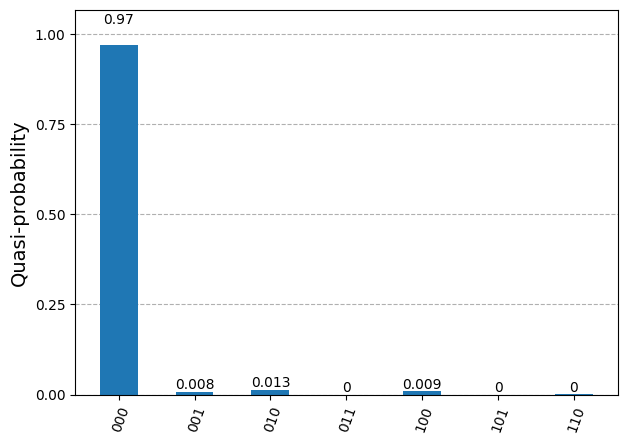

In [78]:
plot_distribution(dist)

### Add noise to simulate real devices

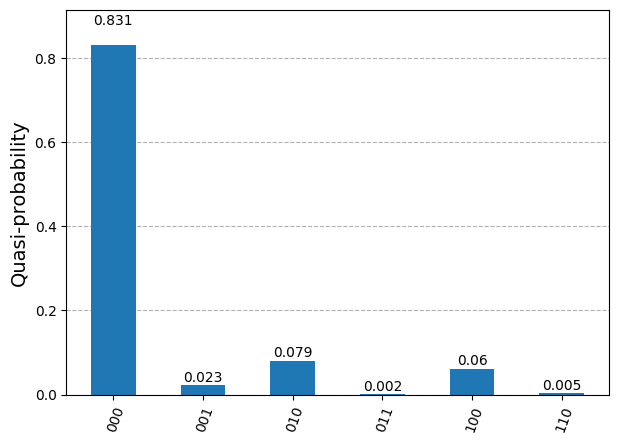

In [79]:
backend = AerSimulator()
noise_model = NoiseModel.from_backend(provider)
pass_manager = generate_preset_pass_manager(backend=provider, optimization_level=1)
isa_qc = pass_manager.run(circuit)

result = backend.run(isa_qc, noise_model=noise_model).result()

dist = result.get_counts()

plot_distribution(dist)